In [1]:
from sys import stdout
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyod.models.qmcd import QMCD
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
import astartes as at

In [2]:
## lendo e preparando o dataset
Dados = pd.read_excel('Dados.xlsx',sheet_name='Portatil')
Dados.info()
y = np.asarray(Dados.iloc[:,262])
y = np.asarray(y,dtype='int')
spectrum = np.asarray(Dados.iloc[:,2:258])
mean = np.mean(spectrum[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Columns: 264 entries, ID to % K
dtypes: float64(262), int64(1), object(1)
memory usage: 387.9+ KB


In [3]:
def pls_variable_selection(X, y, max_comp):
    # Define MSE array to be populated
    mse = np.zeros((max_comp, X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):

        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i + 1)
        pls1.fit(X, y)

        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:, 0]))

        # Sort spectra accordingly
        Xc = X[:, sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1] - (i + 1)):
            pls2 = PLSRegression(n_components=i + 1)
            pls2.fit(Xc[:, j:], y)

            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)

            mse[i, j] = mean_squared_error(y, y_cv)

        comp = 100 * (i + 1) / (max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx, mseminy = np.where(mse == np.min(mse[np.nonzero(mse)]))

    # print("Optimised number of PLS components: ", mseminx[0] + 1)
    # print("Wavelengths to be discarded ", mseminy[0])
    # print('Optimised MSE ', mse[mseminx, mseminy][0])
    # stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()

    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0] + 1)
    pls.fit(X, y)

    sorted_ind = np.argsort(np.abs(pls.coef_[:, 0]))

    Xc = X[:, sorted_ind]

    return (Xc[:, mseminy[0]:], mseminx[0] + 1, mseminy[0], sorted_ind)

def find_Best_Spectrum(X,y):
    menor = len(X[0])
    optimalPLSComponents = 1
    optimalSpectrum = X
    for i in range(1,15):
        opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, i)
        if wav < menor:
            menor = wav
            optimalPLSComponents = ncomp
            optimalSpectrum = opt_Xc

    return (optimalSpectrum,optimalPLSComponents)

def optimalNumbersForKennardStoneMethod(X_train,y_train,X_test,y_test):
    maior = 0
    val_l = 1
    for i in range(1,len(selectedSpectrum[0])):
        overfit, score = kennardStonePLS(X_train, y_train, X_test, y_test, i)
        if score > maior:
           maior = score
           val_l = i
    return val_l


def kennardStonePLS(X_train, y_train,X_test, y_test, n_components):
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)

    y_calib = pls.predict(X_train)
    y_pred = pls.predict(X_test)

    # metrics in prediction
    rmse_p, mae_p, score_p = np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    rmse_calib, mae_p, score_calib = np.sqrt(mean_squared_error(y_train, y_calib)), mean_absolute_error(y_train, y_calib), r2_score(
        y_train, y_calib)

    return (abs(score_calib - score_p), score_p)

def findBestContamination(X, y):
    score = 0
    bestContamination = 0
    bestXSpectrum = X
    bestYSpectrum = y
    optimal = 0
    for i in range(30):
        clf = QMCD(contamination=0.01 + (i / 100))
        print("Contamination:", 0.01 + (i / 100))

        clf.fit(X, y)
        outliers = clf.labels_

        indexes = []

        for k in range(len(outliers)):
            if (outliers[k] == 1):
                indexes.append(k)

        X1 = np.delete(X, indexes, 0)
        y1 = np.delete(y, indexes)

        X_train, X_test, y_train, y_test = at.train_test_split(X1, y1, test_size=0.30)

        opt = optimalNumbersForKennardStoneMethod(X_train, y_train, X_test, y_test)

        overfit, newScore = kennardStonePLS(X_train, y_train, X_test, y_test, opt)
        if (newScore > score and overfit < 0.03):
            score = newScore
            bestContamination = 1 + i
            bestXSpectrum = X1
            bestYSpectrum = y1
            optimal = opt

    return (bestXSpectrum,bestYSpectrum, bestContamination,optimal)
def printKennardStonePLS(X_train, y_train,X_test, y_test, n_components):
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)

    y_calib = pls.predict(X_train)
    y_pred = pls.predict(X_test)

    # metrics in prediction
    ## Calibration Metrics
    rmse_calib, mae_calib, score_calib, sdc = np.sqrt(mean_squared_error(y_train, y_calib)), mean_absolute_error(
        y_train, y_calib), r2_score(y_train, y_calib), np.std(y_train)
    rpdc = sdc / rmse_calib
    ## Validation Metrics
    rmse_p, mae_p, score_p, sd = np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test,
                                                                                                  y_pred), r2_score(
        y_test, y_pred), np.std(y_test)
    rpd = sd / rmse_p

    print('R2 Calib: %5.3f' % score_calib)
    print('R2 CV: %5.3f' % score_p)
    print('MSE Calib: %5.3f' % rmse_calib)
    print('MSE CV: %5.3f' % rmse_p)
    print("MAE Calib: %5.3f" % mae_calib)
    print("MAE Valid: %5.3f" % mae_p)
    print("RPDC : %5.3f" % rpdc)
    print("RPD : %5.3f" % rpd)

    z = np.polyfit(y_test, y_pred, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_pred, y_test, c='red', edgecolors='k')
        ax.plot(z[1] + z[0] * y_test, y_test, c='blue', linewidth=1)
        ax.plot(y_test, y_test, color='green', linewidth=1)
        plt.title('$R^{2}$: ' + str(score_p))
        plt.xlabel('Potassio Predito (ppm)')
        plt.ylabel('Potassio Medido (ppm)')

        plt.show()

def snv(input_data):

    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data

In [4]:
w = 17
p = 2

savitskyGolaySpectrum= savgol_filter(spectrum, w, polyorder=p, deriv=1)

In [5]:
SNVspectrum = snv(savitskyGolaySpectrum)

In [6]:
selectedSpectrum, optimalPLSComponents = find_Best_Spectrum(SNVspectrum,y)

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


33% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


66% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


16% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


33% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


66% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


83% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


28% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


42% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


57% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


71% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


85% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


37% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


62% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


87% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


11% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


22% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


33% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


44% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


55% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


66% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


77% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


88% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


70% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


9% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


18% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


27% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


36% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


45% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


54% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


63% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


72% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


81% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


8% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


16% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


33% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


41% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


58% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


66% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


83% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


91% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


15% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


23% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


38% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


46% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


53% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


61% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


69% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


76% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


84% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


92% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


7% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


14% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


21% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


28% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


35% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


42% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


57% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


64% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


71% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


78% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


85% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


92% completed

C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed


C:\Users\vinic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [7]:
spectrumWithoutOutliers, y ,c, opt = findBestContamination(selectedSpectrum,y)

Contamination: 0.01


D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.7

Contamination: 0.02
Contamination: 0.03
Contamination: 0.04
Contamination: 0.05
Contamination: 0.060000000000000005
Contamination: 0.06999999999999999
Contamination: 0.08
Contamination: 0.09
Contamination: 0.09999999999999999
Contamination: 0.11
Contamination: 0.12
Contamination: 0.13
Contamination: 0.14
Contamination: 0.15000000000000002
Contamination: 0.16
Contamination: 0.17
Contamination: 0.18000000000000002
Contamination: 0.19
Contamination: 0.2
Contamination: 0.21000000000000002
Contamination: 0.22
Contamination: 0.23
Contamination: 0.24000000000000002
Contamination: 0.25
Contamination: 0.26
Contamination: 0.27
Contamination: 0.28
Contamination: 0.29000000000000004


D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.7

Contamination: 0.3


D:\Material\AmostrasLarissa\venv\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(


In [8]:
X_train, X_test, y_train, y_test = at.train_test_split(spectrumWithoutOutliers, y, test_size = 0.30)

D:\Material\AmostrasLarissa\venv\lib\site-packages\astartes\main.py:357: NormalizationWarning: Requested train/test split (0.75, 0.30) do not sum to 1.0, normalizing to train=0.71, test=0.29.
  warn(


R2 Calib: 0.221
R2 CV: 0.247
MSE Calib: 3520.406
MSE CV: 2875.200
MAE Calib: 1896.984
MAE Valid: 2079.597
RPDC : 1.133
RPD : 1.152


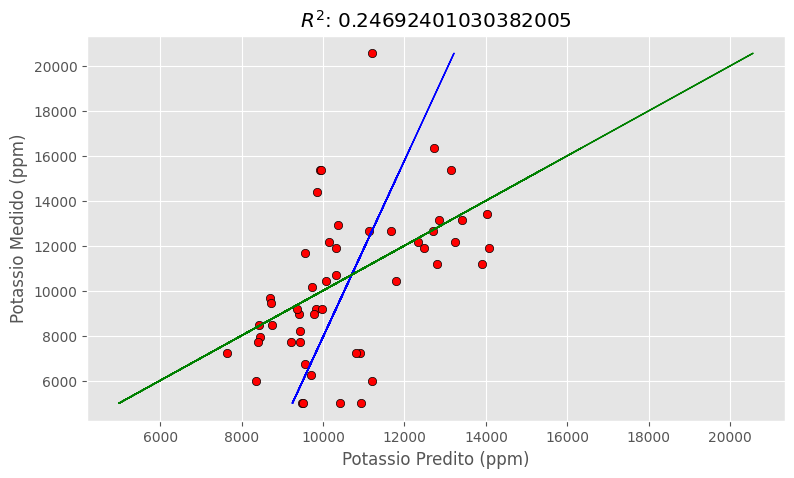

In [9]:
printKennardStonePLS(X_train, y_train, X_test, y_test, opt)